In [10]:
%matplotlib inline
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from itertools import pairwise
from tqdm import trange
rand_seed = 42
torch.manual_seed(rand_seed)

In [2]:
def select_device(use_cuda=True):
    use_cuda = use_cuda and torch.cuda.is_available()
    name = 'cuda:0' if use_cuda else 'cpu'
    return torch.device(name)

In [3]:
def loaders_from_dataset(dataset, device, split=0.8, batch_size=256):
    ''' This might look redundant, but allows the data to always be on the gpu. '''
    tn = int(split * len(dataset))
    vn = len(dataset) - tn
    ts, vs = torch.utils.data.random_split(dataset, lengths=[tn, vn])
    tl = torch.utils.data.DataLoader(ts, shuffle=True, batch_size=len(ts))
    vl = torch.utils.data.DataLoader(vs, shuffle=False, batch_size=len(vs))
    _, (tx, ty) = next(enumerate(tl))
    _, (vx, vy) = next(enumerate(vl))    
    ts = torch.utils.data.TensorDataset(tx.to(device), ty.to(device)) 
    vs = torch.utils.data.TensorDataset(vx.to(device), vy.to(device))
    params = dict(batch_size=batch_size)
    tl = torch.utils.data.DataLoader(ts, shuffle=True, **params)
    vl = torch.utils.data.DataLoader(vs, shuffle=False, **params)
    return tl, vl

def calculate_accuracy(x, y):
    assert(x.size() == y.size())
    assert(x.nelement() == x.size(0))
    return (x == y).sum() / torch.numel(x)

def train_and_validate_step(dataloader, model, optim, loss_func, train=False):
    losses = []
    accuracies = []
    
    for x, y in dataloader:

        if train:
            optim.zero_grad(set_to_none=True)
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            loss.backward()
            optim.step()
        else:
            with torch.no_grad():
                y_pred = model(x)
                loss = loss_func(y_pred, y)
        
        acc = calculate_accuracy(y_pred.argmax(dim=1), y)
        losses.append(loss)
        accuracies.append(acc)

    return torch.mean(torch.Tensor(losses)), torch.mean(torch.Tensor(accuracies))

def train_and_validate(model, tl, vl, optim, loss_func, epochs, **kwargs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    model.train()
    for _ in trange(epochs):
        loss, acc = train_and_validate_step(tl, model, optim, loss_func, train=True)
        train_losses.append(loss)
        train_accuracies.append(acc)
        
        loss, acc = train_and_validate_step(tl, model, optim, loss_func, train=True)
        val_losses.append(loss)
        val_accuracies.append(acc)

    return train_losses, train_accuracies, val_losses, val_accuracies

In [4]:
class MLP(torch.nn.Module):
    def __init__(self, shape = (784, 100, 100, 10), funcs = (None, None, None)):
        super().__init__()
        assert(len(shape) == len(funcs) + 1)
        layers = []
        for i, (x, y) in enumerate(pairwise(shape)):
            layers.append(torch.nn.Linear(x, y))
            if funcs[i]:
                layers.append(funcs[i]())
        self.module = torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return self.module(x.flatten(1))

In [5]:
device = select_device()

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
])

params = dict(download=True, transform=transforms)
train_dataset = torchvision.datasets.MNIST("data/", train=True, **params)
test_dataset = torchvision.datasets.MNIST("data/", train=False, **params)
tl, vl = loaders_from_dataset(train_dataset, device, split=0.8, batch_size=256)

In [12]:
act_functions = [
    torch.nn.ReLU,
    torch.nn.ELU,
    torch.nn.Sigmoid,
    torch.nn.Tanh
]

learning_rates = [
    1,
    0.1,
    0.01,
    0.001,
    0.0001,
]

params_list = []
output_list = []

for lr in learning_rates:
    act_func = torch.nn.ReLU
    output_act_func = None
    epochs = 30
    shape = (784, 100, 10)
    funcs = [act_func] * (len(shape) - 2) + [output_act_func]
    model = MLP(shape, funcs).to(device)
    optim = torch.optim.SGD(params=model.parameters(), lr=lr)
    loss_func = torch.nn.CrossEntropyLoss()
    params = dict(epochs=epochs, model=model, optim=optim, loss_func=loss_func, lr=lr,
                  tl=tl, vl=vl, act_func=act_func, output_act_func=output_act_func)
    output = train_and_validate(**params)
    params_list.append(params)
    output_list.append(output)

for act_func in act_functions:
    for output_act_func in [act_func, None]:
        lr = 0.01
        epochs = 30
        shape = (784, 100, 10)
        funcs = [act_func] * (len(shape) - 2) + [output_act_func]
        model = MLP(shape, funcs).to(device)
        optim = torch.optim.SGD(params=model.parameters(), lr=lr)
        loss_func = torch.nn.CrossEntropyLoss()
        params = dict(epochs=epochs, model=model, optim=optim, loss_func=loss_func, lr=lr,
                      tl=tl, vl=vl, act_func=act_func, output_act_func=output_act_func)
        output = train_and_validate(**params)
        params_list.append(params)
        output_list.append(output)

print("Done.")

100%|███████████████████████████████████████████| 30/30 [00:47<00:00,  1.58s/it]

Done.


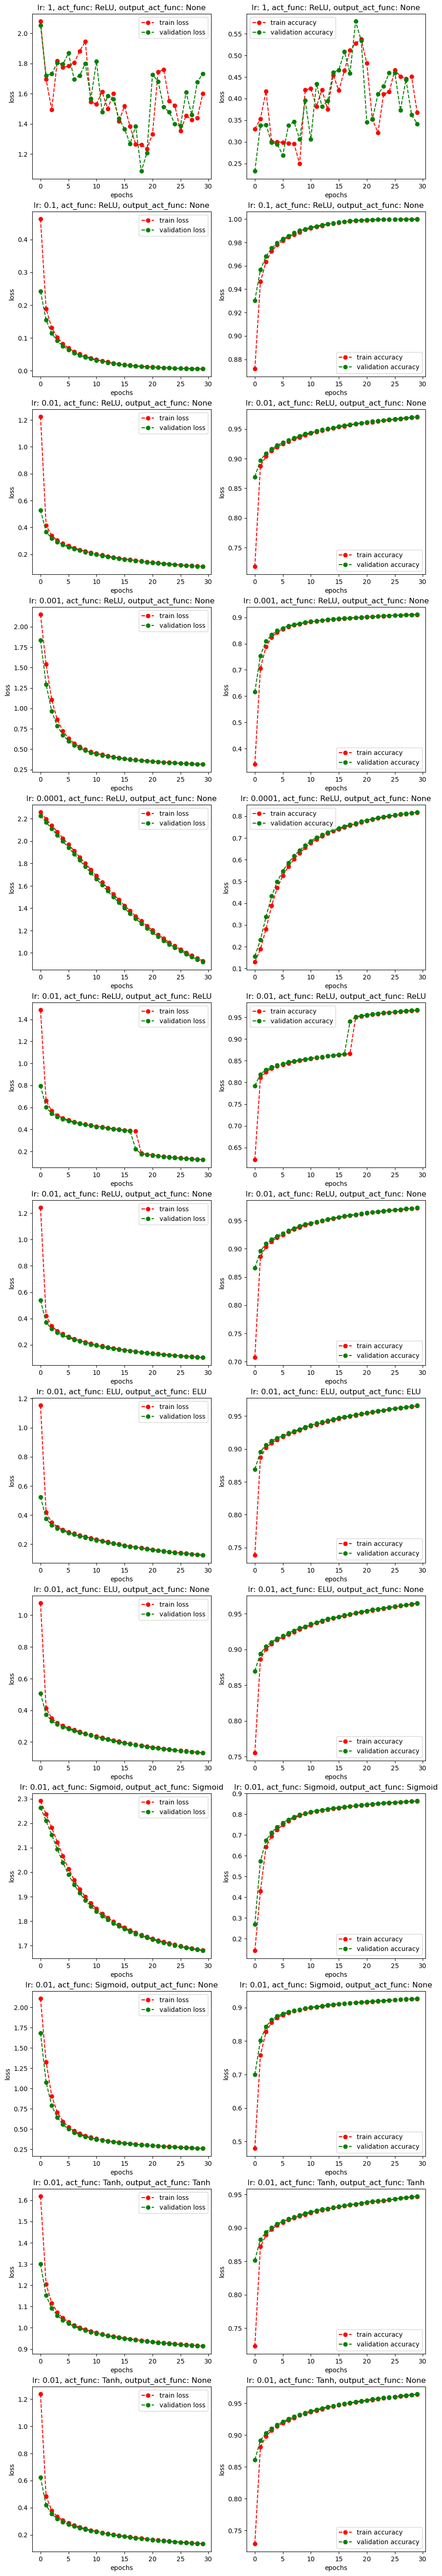

In [13]:
num = len(params_list)
fig = plt.figure(figsize = (11, 11 * num / 2))

for i, (params, output) in enumerate(zip(params_list, output_list)):
    plt.subplot(num, 2, 2 * i + 1)
    plt.plot(output[0], linestyle = '--', marker = 'o', label = 'train loss', c = 'r')
    plt.plot(output[2], linestyle = '--', marker = 'o', label = 'validation loss', c = 'g')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    lr = f'lr: {params["lr"]}'
    act_func = f'act_func: {params["act_func"].__name__ if params["act_func"] else None}'
    output_act_func = f'output_act_func: {params["output_act_func"].__name__ if params["output_act_func"] else None}'
    plt.title(', '.join([lr, act_func, output_act_func]))
    plt.legend()

    plt.subplot(num, 2, 2 * i + 2)
    plt.plot(output[1], linestyle = '--', marker = 'o', label = 'train accuracy', c = 'r')
    plt.plot(output[3], linestyle = '--', marker = 'o', label = 'validation accuracy', c = 'g')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    lr = f'lr: {params["lr"]}'
    act_func = f'act_func: {params["act_func"].__name__ if params["act_func"] else None}'
    output_act_func = f'output_act_func: {params["output_act_func"].__name__ if params["output_act_func"] else None}'
    plt.title(', '.join([lr, act_func, output_act_func]))
    plt.legend()

plt.show()